In [ ]:
!pip install nltk

In [ ]:
import string
import re
import pandas as pd
import nltk
from collections import Counter, OrderedDict
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [43]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
reddit_data = pd.read_csv("/content/drive/MyDrive/dataset/reddit_dataset")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
reddit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365419 entries, 0 to 365418
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  365419 non-null  int64 
 1   title       365418 non-null  object
 2   selftext    365419 non-null  object
 3   subreddit   365419 non-null  object
 4   date        365419 non-null  object
 5   post_len    365419 non-null  int64 
 6   year        365419 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 19.5+ MB


In [46]:
reddit_data['subreddit'].value_counts()

Anxiety          157786
depression       124269
mentalillness     36616
bipolar           35273
schizophrenia     11475
Name: subreddit, dtype: int64

In [ ]:
reddit_posts = reddit_data.sort_values(by = ['date'])

In [ ]:
reddit_data['date'] = pd.to_datetime(reddit_data['date'])  # Convert the 'date' column to datetime

# Extract year from the 'date' column and create a new 'year' column
reddit_data['year'] = reddit_data['date'].dt.year

# Group by year and count the number of posts in each year
yearly_counts = reddit_data.groupby('year')['date'].count()

In [45]:
reddit_data['year'].value_counts()

2022    225972
2021    111081
2020     18820
2019      4730
2018      2042
2016      1513
2017      1261
Name: year, dtype: int64

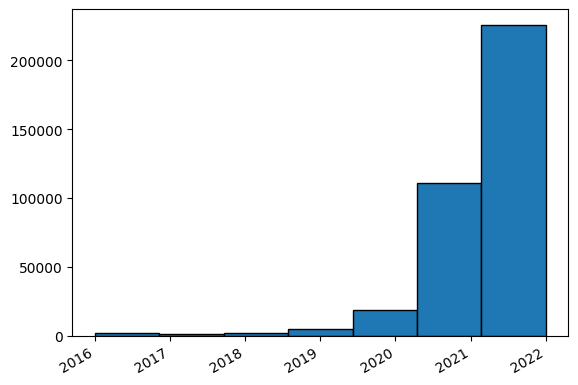

In [ ]:
#frequency of posts over the years
from matplotlib import pyplot as plt, dates as mdates
plt.hist(yearly_counts.index, bins=len(yearly_counts), weights=yearly_counts.values, edgecolor='black')
plt.xticks(yearly_counts.index)
plt.gcf().autofmt_xdate()
plt.show()

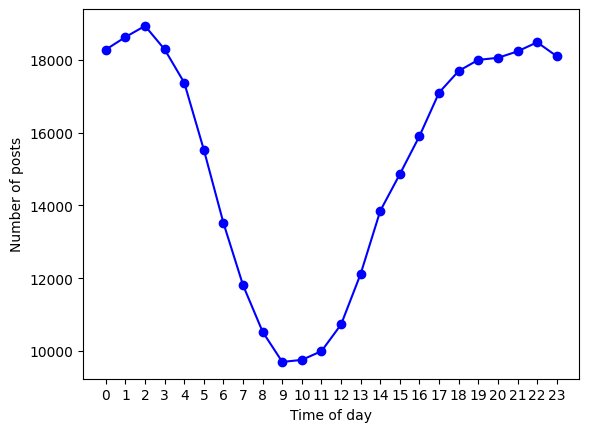

In [ ]:
reddit_data['date'] = pd.to_datetime(reddit_data['date'])

# Extract the time of day from the timestamp
reddit_data['hour'] = reddit_data['date'].dt.hour

# Group and count posts by time of day
grouped = reddit_data.groupby('hour').size().reset_index(name='post_count')

# Plot the compound scores
plt.plot(grouped.index, grouped.post_count, marker='o', linestyle='-', color='b')
plt.xlabel('Time of day')
plt.ylabel('Number of posts')
plt.xticks(grouped.index)


plt.show()

Defining Preprocess function which is used based on the task

In [ ]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

def separating_punctuation(text):
    '''Separating out the punctuation'''
    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text) # separates punctuation at ends of strings
    text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text) # separates punctuation at beginning of strings
    return text

def remove_puntuation(text):
    '''Remove punctuation from the lines'''
    return re.sub(r'[^\w\s]', ' ', text)

def convert_to_lowercase(tokens):
    '''Convert all the tokens to lower case'''
    return [token.lower() if token.isalpha() else token for token in tokens]

def remove_URL(text):
    """Remove URLs from a string"""
    return re.sub(r"http\S+", "", text)

def remove_stopwords(tokens):
    '''Remove stop words i.e. the words that occur commonly. stopword from nltk is used for this step'''
    stopword_list = nltk.corpus.stopwords.words('english')
    # filtered_tokens = []
    # for token in tokens:
    #   if token.isalpha():
    filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    return filtered_tokens

def apply_lemmatization(tokens):
    '''Lemmatize the token i.e. switches the word to its base root'''
    wnl=WordNetLemmatizer()
    tokens = [wnl.lemmatize(token) for token in tokens]
    return tokens

def apply_stemming(tokens, ps=PorterStemmer()):
    '''Stemming the token to reduce it to its base form.'''
    return [ps.stem(t) for t in tokens]

In [ ]:
def pre_process(post_text):
    """Pre-process all the posts,
    using tokenization, spelling normalization and other techniques.
    """
    #post_text = separating_punctuation(post_text)

    #post_text = remove_puntuation(post_text)

    post_text = remove_URL(post_text.strip())

    tokens = post_text.split()

    tokens = convert_to_lowercase(tokens)

    #tokens = remove_stopwords(tokens)

    #post_text = ' '.join(tokens)

    #post_text = remove_puntuation(post_text)

    #tokens = post_text.split()

    #tokens = remove_stopwords(tokens)

    #tokens = apply_lemmatization(tokens)

    #tokens = apply_stemming(tokens)

    #print(tokens)
    #return tokens #
    return ' '.join(tokens)

Model for Suicidal Content Detection

In [ ]:
!pip install setfit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 101.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.0 MB/s eta 0:00

In [ ]:
from datasets import load_dataset
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer
from datasets import Value, ClassLabel, Features

In [ ]:
data_suicide = pd.read_csv("/content/drive/MyDrive/dataset/Suicide_Detection.csv")

In [ ]:
data_suicide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      300 non-null    int64 
 1   text    300 non-null    object
 2   label   300 non-null    object
dtypes: int64(1), object(2)
memory usage: 7.2+ KB


In [ ]:
data_suicide['label'].value_counts()

non-suicide    171
suicide        129
Name: label, dtype: int64

In [ ]:
train_data_suicide = load_dataset('csv', data_files=['Suicide_Detection.csv'], split='train[:60%]')
test_data_suicide = load_dataset('csv', data_files=['Suicide_Detection.csv'], split='train[-40%:]')

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
train_data_suicide = train_data_suicide.remove_columns("id")
test_data_suicide = test_data_suicide.remove_columns("id")

In [ ]:
train_data_suicide

Dataset({
    features: ['id', 'text', 'label'],
    num_rows: 180
})

In [ ]:
def change_to_int(x):
  if x['label'] == 'suicide':
    x['label']= 1
  else:
     x['label'] = 0
  return x

In [ ]:
train_data_suicide = train_data_suicide.map(lambda x: change_to_int(x))
test_data_suicide = test_data_suicide.map(lambda x: change_to_int(x))

Map:   0%|          | 0/180 [00:00<?, ? examples/s]

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

In [ ]:
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")



model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [ ]:
# Createing trainer
trainer = SetFitTrainer(
    model=model,
    train_dataset=train_data_suicide,
    eval_dataset=test_data_suicide,
    loss_class=CosineSimilarityLoss,
    batch_size=6,
    num_iterations=20,
    num_epochs=1,
    metric="f1",
    metric_kwargs={"average": "weighted"},
)

In [ ]:
trainer.train()

Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 7200
  Num epochs = 1
  Total optimization steps = 1200
  Total train batch size = 6


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1200 [00:00<?, ?it/s]

In [ ]:
metrics = trainer.evaluate()


***** Running evaluation *****


In [ ]:
print(metrics)

{'f1': 0.958164161739915}


In [ ]:
p = model(["i wanna die!", "i have anxiety", "i am extremely sad","i don't see any point in living"])
p

tensor([1, 0, 0, 1])

In [ ]:
pred = model(["Yes I am here again. I don't really expect anyone to see this, or even reply to this but I just want to type something, but if you can, and have the time, I would like you to chat with me. Anyone. Send me a private message please. I just want to talk. Spoiler Alert: It maybe childish to some of you, if it is, don't tell me. Alright here we go. It all started when I was in the study tour to Switzerland about two months ago.There's a girl, that I know she existed, but never talked to her. For some reason, I feel like it's a good time to, you know, give life a try, so I did (I am not going into the details here because I don't even remember what happened and what I did.)It was day five, and we're going to the Jungfraujoch (a very high snow mountain in Switzerland). You know, as I was trying, I stayed kind of close to her.It turns out that my lungs aren't very good, and I felt horrible up on the mountain. For some reason she chose to stay with me throughout the whole day up on the mountain. It was all very nice, up until the point when we're trying to get off the mountain.If you don't know, directly looking at snow without a sunglasses can cause you illness. (If I remember correctly) She took off her sunglasses because they're uncomfortable. It was not a problem, since most of the train journey was inside the tunnel, but once we got out of the tunnel, she started to feel dizzy and headache and stuff like that. On the train, I was sitting beside her (I used a lot of excuses to made that happened, for example, so that we can take a look at the Swiss Army Knife we have just bought), so she laid her head on my shoulder.After the train journey, because we need to go into a indoor area to wait for the next train, so I kind of hugging/pulling her into the room. After that, things went well. We are kind of dating while sort of acting like there is nothing because we are both too shy to say it out.A few days later, I felt she started to hate me (I dont know the reason at the time), so I tried to forget her in extreme depression. I even almost cried on the plane journey back to Hong Kong.A few days later, after we are back to Hong Kong, she sent me a message. Turns out its not that she dont love me or anything, but rather because of some personal problem (which I am obviously not gonna say here), so she is afraid that I will be mean to her. After some chatting, we decided to try to date.Up until this point, that was one of the best day in my life. Not only because I have girlfriend with my horrible looking and a fat body; but also because I have proven myself not to be a piece of crap.One week later was my birthday. I originally asked her out for a walk after school, but it turns out that she needs to prepare for the study tour showcase the week after my birthday, so she needs to stay behind. Of course its my god dang birthday I want to walk with her, so I asked does she wants me to wait for her, and she replied no. And for no reason at all I chose to stay behind, using waiting for another friend as an excuse, and I will regret that decision forever.The moment she got down to the ground floor, there is another friend of mine talking to her; to outsiders like myself, which knows basically nothing, in our eyes my friend was flirting, and she seems to be enjoying it. At that point I have realized I have screwed everything up. AGAIN.Instead of talking to her anymore, I decided to step down before everything has gotten worse. I surrender.Ive realized I am not as good as others, and there will be no chance for me at all.Whats worse is the week after Ive surrender, they have started dating. THEY ARE FUCKING DATING. AND THE GIRL WAS TAKEN FROM ME. AND I haVE TREATED THAT FRIEND OF MINE AS MY BROTHER. LOOK WHAT HE HAS GIVEN TO ME AS MY BIRTHDAY PRESENT!Anyways, in their eyes, I gave up. In my eyes, and basically everyone else at school, my girlfriend got stolen.Although I have talked about this many many times in different venue to different people, every time I see them, I just cannot forget the happy moments we have been through in Switzerland. I am still extremely depressed after all these time.FML TL;DR: Ive fucked up again, but this time its partly because my girlfriend got stolen from me."])

In [ ]:
print(pred)

tensor([0])


Evaluating model on labeled suicide_dataset test data

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/dataset/suicide_test_1.csv')

In [ ]:
predicted = model((test['text']).tolist())

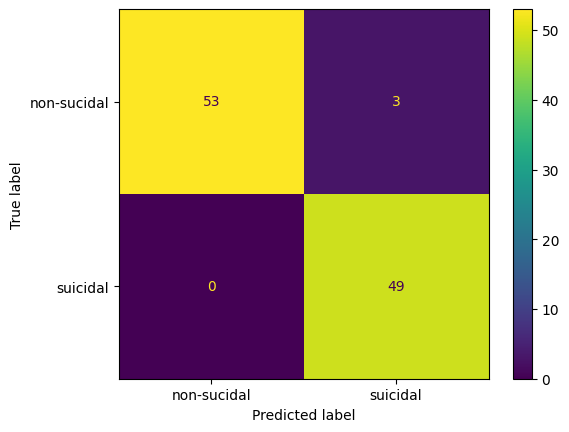

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm =confusion_matrix(test['label'].astype(int),predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['non-sucidal', 'suicidal'])
disp.plot()

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/dataset/reddit_test_1.csv')

In [ ]:
predicted = model((test['selftext']).tolist())

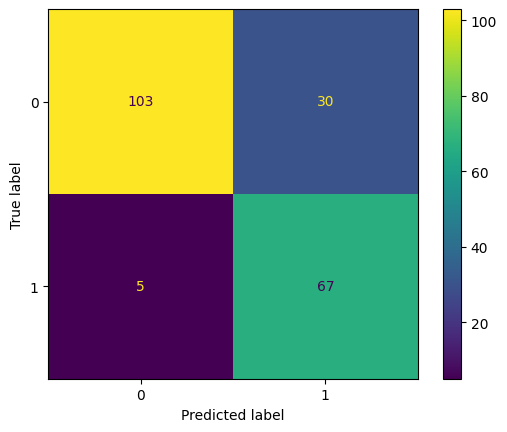

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm =confusion_matrix(test['label'].astype(int),predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['non-sucidal', 'suicidal'])
disp.plot()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test['label'].astype(int), predicted, target_names=['non-suicidal','suicidal']))

              precision    recall  f1-score   support

non-suicidal       0.95      0.77      0.85       133
    suicidal       0.69      0.93      0.79        72

    accuracy                           0.83       205
   macro avg       0.82      0.85      0.82       205
weighted avg       0.86      0.83      0.83       205



Saving this model for using it in analysis

In [ ]:
model.save_pretrained("/content/drive/MyDrive/dataset/model_4/")

In [ ]:
model = SetFitModel.from_pretrained('/content/drive/MyDrive/dataset/model_4/')

Annotating Rows related to anxiety disorder, depressive disorder, bipolar disorder, schizophrenia disorder

In [ ]:
!pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer, util
import torch

In [ ]:
embedder = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
corpus = reddit_data['selftext'].tolist()
cp = corpus

In [ ]:
corpus_embeddings = embedder.encode(corpus, convert_to_tensor=True)

In [ ]:
queries = ['general anxiety disorder','panic disorder','social anxiety disorder','anxiety disorder','panic attacks','separation anxiety disorder']

In [ ]:
scores = []
for query in queries:
  query_embedding = embedder.encode(query, convert_to_tensor=True)
  # We use cosine-similarity the scores
  cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
  scores.append(cos_scores.tolist())

max_score = []
for j in range(len(scores[0])):
  scores_j = []
  for i in range(len(queries)):
    scores_j.append(scores[i][j])
  max_score.append(max(scores_j))

In [ ]:
reddit_data['anxiety'] = max_score

In [ ]:
queries = ['bipolar disorder','bipolar']

In [ ]:
scores = []
for query in queries:
  query_embedding = embedder.encode(query, convert_to_tensor=True)
  # We use cosine-similarity the scores
  cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
  scores.append(cos_scores.tolist())

max_score = []
for j in range(len(scores[0])):
  scores_j = []
  for i in range(len(queries)):
    scores_j.append(scores[i][j])
  max_score.append(max(scores_j))

In [ ]:
reddit_data['bipolar'] = max_score

In [ ]:
queries = ['schizophrenia','schizo']

In [ ]:
scores = []
for query in queries:
  query_embedding = embedder.encode(query, convert_to_tensor=True)
  # We use cosine-similarity the scores
  cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
  scores.append(cos_scores.tolist())

max_score = []
for j in range(len(scores[0])):
  scores_j = []
  for i in range(len(queries)):
    scores_j.append(scores[i][j])
  max_score.append(max(scores_j))

In [ ]:
reddit_data['schizophrenia'] = max_score

In [ ]:
queries = ['depression', 'clinical depression','depressive disorder']

In [ ]:
scores = []
for query in queries:
  query_embedding = embedder.encode(query, convert_to_tensor=True)
  # We use cosine-similarity the scores
  cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
  scores.append(cos_scores.tolist())

max_score = []
for j in range(len(scores[0])):
  scores_j = []
  for i in range(len(queries)):
    scores_j.append(scores[i][j])
  max_score.append(max(scores_j))

In [ ]:
reddit_data['depression'] = max_score

In [ ]:
reddit_data.to_csv('/content/drive/MyDrive/dataset/reddit_data_scored.csv')

Now, using the sampled scored data, it is labelled manually and threshold is found using cohen's kappa score.

In [ ]:
disorder_labelled = pd.read_csv("/content/drive/MyDrive/dataset/disorder_labelled_2.csv")

In [ ]:
sample_scored = pd.read_csv("/content/drive/MyDrive/dataset/sample_scored.csv")

In [ ]:
similarity_score_thresholds = [0.2,0.3,0.34,0.36,0.4] #similarity scores considered as thresholds

In [ ]:
def convert_to_label(score,thresold):
  '''converts labels to 1 if the score is above threshold otherwise label it 0'''
  if score >= thresold:
    label = 1
  else:
     label = 0
  return label


In [ ]:
labels_for_threshold = sample_scored['anxiety'].apply(lambda x: convert_to_label(x,0.36))

In [ ]:
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(labels_for_threshold.tolist(),disorder_labelled['anxiety']))

0.7042640990371389


In [ ]:
labels_for_threshold = sample_scored['bipolar'].apply(lambda x: convert_to_label(x,0.36))

In [ ]:
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(labels_for_threshold.tolist(),disorder_labelled['bipolar']))

0.8152628106443809


In [ ]:
labels_for_threshold = sample_scored['schizophrenia'].apply(lambda x: convert_to_label(x,0.36))

In [ ]:
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(labels_for_threshold.tolist(),disorder_labelled['schizophrenia']))

0.7741176470588236


In [ ]:
labels_for_threshold = sample_scored['depression'].apply(lambda x: convert_to_label(x,0.36))

In [ ]:
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(labels_for_threshold.tolist(),disorder_labelled['depression']))

0.7050691244239631


Threshold of 0.36 Maximizes the Cohen's Kappa score. Therefore it is selected to label the data.

In [ ]:
anxiety = reddit_data[reddit_data['anxiety']>=0.36]
anxiety.to_csv('/content/drive/MyDrive/dataset/anxiety.csv')

In [ ]:
bipolar = reddit_data[reddit_data['bipolar']>=0.36]
bipolar.to_csv('/content/drive/MyDrive/dataset/bipolar.csv')

In [ ]:
schizophrenia = reddit_data[reddit_data['schizophrenia']>=0.36]
schizophrenia.to_csv('/content/drive/MyDrive/dataset/schizophrenia.csv')

In [ ]:
depression = reddit_data[reddit_data['depression']>=0.36]
depression.to_csv('/content/drive/MyDrive/dataset/depression.csv')

Sentiment Analysis

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


N-gram Analysis

In [ ]:
def preprocess_and_get_corpus(dataset):
  corpus=[]
  pre_processed= dataset['selftext'].astype('str').apply(lambda x: pre_process(x))
  pre_processed=pre_processed.values.tolist()
  corpus=[word for i in pre_processed for word in i]
  return corpus

In [ ]:
stopword_list = nltk.corpus.stopwords.words('english')
print(stopword_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n),stop_words=stopword_list).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

Analysis of Long and Small Posts (RQ1)

using 280 as it is the length of a tweet.

In [ ]:
small_posts = reddit_data[ reddit_data['post_len']<280]
long_posts = reddit_data[ reddit_data['post_len']>=280]

In [ ]:
small_posts = small_posts[ small_posts['post_len']>10 ]

In [ ]:
small_posts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81717 entries, 6 to 365416
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   Unnamed: 0  81717 non-null  int64              
 1   title       81717 non-null  object             
 2   selftext    81717 non-null  object             
 3   subreddit   81717 non-null  object             
 4   date        81717 non-null  datetime64[ns, UTC]
 5   post_len    81717 non-null  int64              
 6   year        81717 non-null  int64              
 7   hour        81717 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(4), object(3)
memory usage: 5.6+ MB


In [ ]:
long_posts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283336 entries, 0 to 365418
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype              
---  ------      --------------   -----              
 0   Unnamed: 0  283336 non-null  int64              
 1   title       283335 non-null  object             
 2   selftext    283336 non-null  object             
 3   subreddit   283336 non-null  object             
 4   date        283336 non-null  datetime64[ns, UTC]
 5   post_len    283336 non-null  int64              
 6   year        283336 non-null  int64              
 7   hour        283336 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(4), object(3)
memory usage: 19.5+ MB


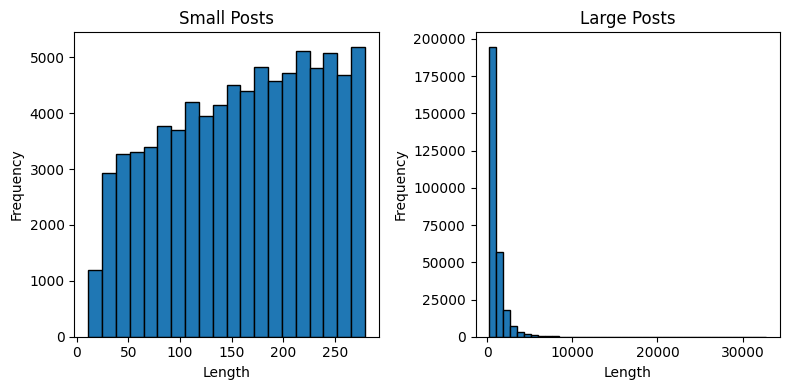

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(8,4))
small_posts['post_len']
ax1.hist(small_posts['post_len'], bins=20, edgecolor='black')
ax1.set_xlabel('Length of post')
ax1.set_ylabel('Frequency')
ax1.set_title('Small Posts')
#ax1.grid(True)

ax2.hist(long_posts['post_len'], bins=40, edgecolor='black')
ax2.set_xlabel('Length')
ax2.set_ylabel('Frequency')
ax2.set_title('Large Posts')
#ax2.grid(True)

plt.tight_layout()
plt.show()

Labeling as having suicidal or non-suicidal content using our model

In [ ]:
small_post_labels = small_posts['selftext'].astype('str').apply(lambda x: model([x])[0].item())

In [ ]:
small_posts.insert(12, "label", small_post_labels.tolist(), True)

In [ ]:
preds_long = long_posts['selftext'].astype('str').apply(lambda x: model([x])[0].item())

In [ ]:
long_posts.insert(12, "label", preds_long.tolist(), True)

In [ ]:
suicidal_long_posts = long_posts[long_posts['label']==1]

In [ ]:
print("Percentage of suicidal long posts: ",(len(suicidal_long_posts)/len(long_posts))*100 )

Percentage of suicidal long posts:  57.49040009035209


In [ ]:
suicidal_small_posts = small_posts[small_posts['label']==1]

In [ ]:
print("Percentage of suicidal small posts: ",(len(suicidal_small_posts)/len(small_posts))*100 )

Percentage of suicidal small posts:  23.137168520626066


More suicidal posts than non-suicidal posts in longer narratives

Sentiment Analysis of long and short posts:

In [ ]:
pre_small_posts= suicidal_small_posts['selftext'].astype('str').apply(lambda x: pre_process(x))

In [ ]:
suicidal_small_posts['scores'] = pre_small_posts.apply(lambda post: analyzer.polarity_scores(post))

In [ ]:
suicidal_small_posts['compound']  = suicidal_small_posts['scores'].apply(lambda score_dict: score_dict['compound'])
suicidal_small_posts['comp_score'] = suicidal_small_posts['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')
suicidal_small_posts.head()

In [ ]:
pre_long_posts= suicidal_long_posts['selftext'].astype('str').apply(lambda x: pre_process(x))

In [ ]:
suicidal_long_posts['scores'] = pre_long_posts.apply(lambda post: analyzer.polarity_scores(post))

<ipython-input-333-33bb99c40480>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suicidal_long_posts['scores'] = suicidal_long_posts['selftext'].apply(lambda post: analyzer.polarity_scores(post))


In [ ]:
suicidal_long_posts['compound']  = suicidal_long_posts['scores'].apply(lambda score_dict: score_dict['compound'])
suicidal_long_posts['comp_score'] = suicidal_long_posts['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')

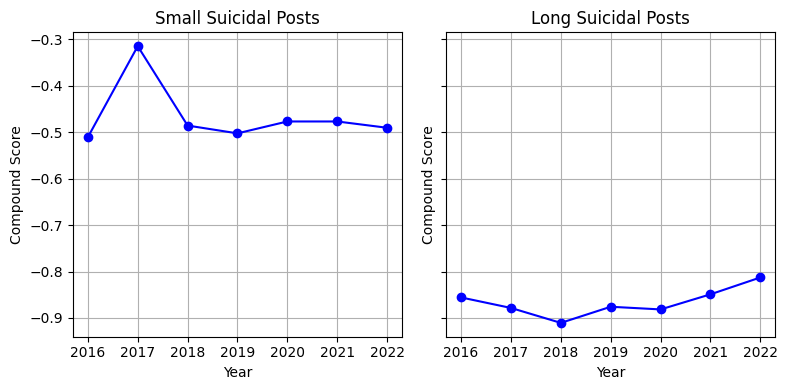

In [ ]:
yearly_compound_score = suicidal_small_posts[['compound','year']].groupby('year')['compound'].median()

x_values = range(len(suicidal_small_posts['compound']))

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(8,4),sharey=True)

# Plot the compound scores
ax1.plot(yearly_compound_score.index, yearly_compound_score, marker='o', linestyle='-', color='b')
ax1.set_xlabel('Year')
ax1.set_ylabel('Compound Score')
ax1.set_title('Small Suicidal Posts')
#ax1.xticks(yearly_compound_score.index)
ax1.grid(True)

yearly_compound_score = suicidal_long_posts[['compound','year']].groupby('year')['compound'].median()

x_values = range(len(suicidal_long_posts['compound']))

# Plot the compound scores
ax2.plot(yearly_compound_score.index, yearly_compound_score, marker='o', linestyle='-', color='b')
ax2.set_xlabel('Year')
ax2.set_ylabel('Compound Score')
ax2.set_title('Long Suicidal Posts')
#ax2.xticks(yearly_compound_score.index)
ax2.grid(True)

plt.tight_layout()
plt.show()

N-gram Analysis of Long and short posts

<Axes: >

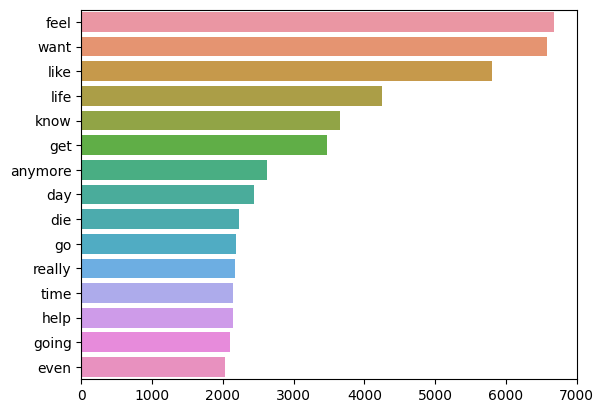

In [ ]:
counter=Counter(preprocess_and_get_corpus(suicidal_small_posts))
most=counter.most_common()

x, y= [], []
for word,count in most[:15]:
  if (word not in stopword_list):
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

<Axes: >

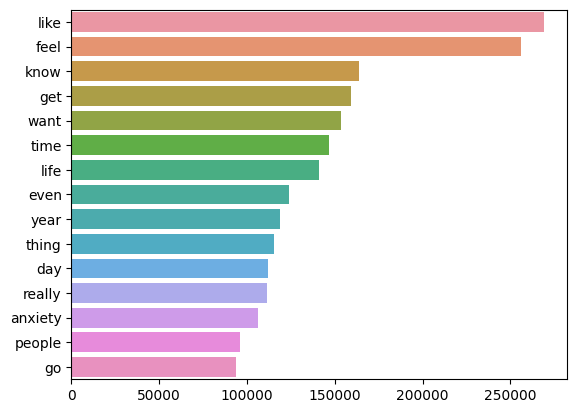

In [ ]:
counter=Counter(preprocess_and_get_corpus(suicidal_long_posts))
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:15]:
  if (word not in stopword_list):
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

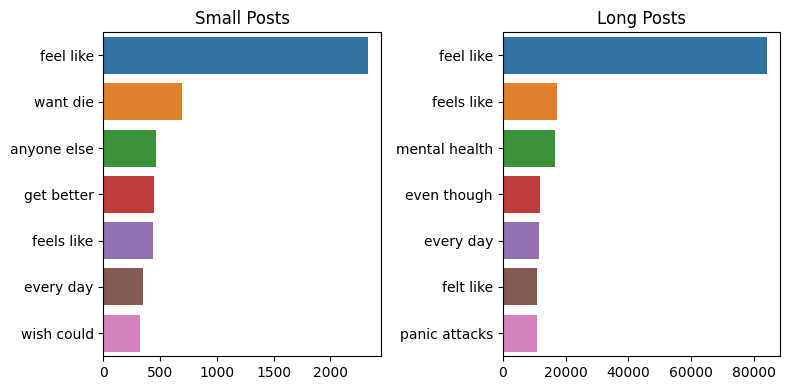

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(8,4))
sp = small_posts[small_posts['label']==1]['selftext'].apply(lambda x : pre_process(x))
lp = long_posts[long_posts['label']==1]['selftext'].apply(lambda x : pre_process(x))

#top_s_bigrams=get_top_ngram(sp.astype('str'),2)
x,y=map(list,zip(*top_s_bigrams[:7]))
sns.barplot(x=y,y=x, ax=ax1)
ax1.set_title('Small Posts')

#sp = small_posts['selftext'].apply(lambda x : pre_process(x))
#top_l_bigrams=get_top_ngram(lp.astype('str'),2)
x,y=map(list,zip(*top_l_bigrams[:7]))
sns.barplot(x=y,y=x, ax=ax2)
ax2.set_title('Long Posts')

plt.tight_layout()
plt.show()

Analysis Based on the four disorders used in the study

Labelling Posts related to the disorders as 'suicidal' or 'non-suicidal'

In [ ]:
preds_depression = depression['selftext'].astype('str').apply(lambda x: model([x])[0].item())
preds_schizophrenia = schizophrenia['selftext'].astype('str').apply(lambda x: model([x])[0].item())
preds_bipolar = bipolar['selftext'].astype('str').apply(lambda x: model([x])[0].item())
preds_anxiety = anxiety['selftext'].astype('str').apply(lambda x: model([x])[0].item())

In [ ]:
depression.insert(14, "label", preds_depression.tolist(), True)
schizophrenia.insert(14, "label", preds_schizophrenia.tolist(), True)
bipolar.insert(14, "label", preds_bipolar.tolist(), True)
anxiety.insert(14, "label", preds_anxiety.tolist(), True)

In [ ]:
suicidal_depression = depression[depression['label']==1]
suicidal_anxiety = anxiety[anxiety['label']==1]
suicidal_schizophrenia = schizophrenia[schizophrenia['label']==1]
suicidal_bipolar = bipolar[bipolar['label']==1]

In [ ]:
print("Percentage of suicidal posts in posts related to depression: ",(len(suicidal_depression)/len(depression))*100 )
print("Percentage of suicidal posts in posts related to anxiety: ",(len(suicidal_anxiety)/len(anxiety))*100 )
print("Percentage of suicidal posts in posts related to schizophrenia: ",(len(suicidal_schizophrenia)/len(schizophrenia))*100 )
print("Percentage of suicidal posts in posts related to bipolar: ",(len(suicidal_bipolar)/len(bipolar))*100 )

Percentage of suicidal posts in posts related to depression:  70.86611665020864
Percentage of suicidal posts in posts related to anxiety:  42.01347305389221
Percentage of suicidal posts in posts related to schizophrenia:  47.6578632757309
Percentage of suicidal posts in posts related to bipolar:  54.903192046049185


Sentiment Analysis using VADER model on the posts related to mental illnesses

In [ ]:
pre_depression_posts= suicidal_depression['selftext'].astype('str').apply(lambda x: pre_process(x))

In [ ]:
suicidal_depression['scores'] = pre_depression_posts.apply(lambda post: analyzer.polarity_scores(post))

In [ ]:
suicidal_depression['compound']  = suicidal_depression['scores'].apply(lambda score_dict: score_dict['compound'])
suicidal_depression['comp_score'] = suicidal_depression['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')


In [ ]:
pre_anxiety_posts= suicidal_anxiety['selftext'].astype('str').apply(lambda x: pre_process(x))
suicidal_anxiety['scores'] = pre_anxiety_posts.apply(lambda post: analyzer.polarity_scores(post))

In [ ]:
suicidal_anxiety['compound']  = suicidal_anxiety['scores'].apply(lambda score_dict: score_dict['compound'])
suicidal_anxiety['comp_score'] = suicidal_anxiety['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')


In [ ]:
pre_schizophrenia_posts= suicidal_schizophrenia['selftext'].astype('str').apply(lambda x: pre_process(x))
suicidal_schizophrenia['scores'] = pre_schizophrenia_posts.apply(lambda post: analyzer.polarity_scores(post))

In [ ]:
suicidal_schizophrenia['compound']  = suicidal_schizophrenia['scores'].apply(lambda score_dict: score_dict['compound'])
suicidal_schizophrenia['comp_score'] = suicidal_schizophrenia['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')

In [ ]:
pre_bipolar_posts= suicidal_bipolar['selftext'].astype('str').apply(lambda x: pre_process(x))
suicidal_bipolar['scores'] = suicidal_bipolar['selftext'].apply(lambda post: analyzer.polarity_scores(post))

<ipython-input-18-7c9b33a5d746>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suicidal_bipolar['scores'] = suicidal_bipolar['selftext'].apply(lambda post: analyzer.polarity_scores(post))


In [ ]:
suicidal_bipolar['compound']  = suicidal_bipolar['scores'].apply(lambda score_dict: score_dict['compound'])
suicidal_bipolar['comp_score'] = suicidal_bipolar['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')
suicidal_bipolar.head()

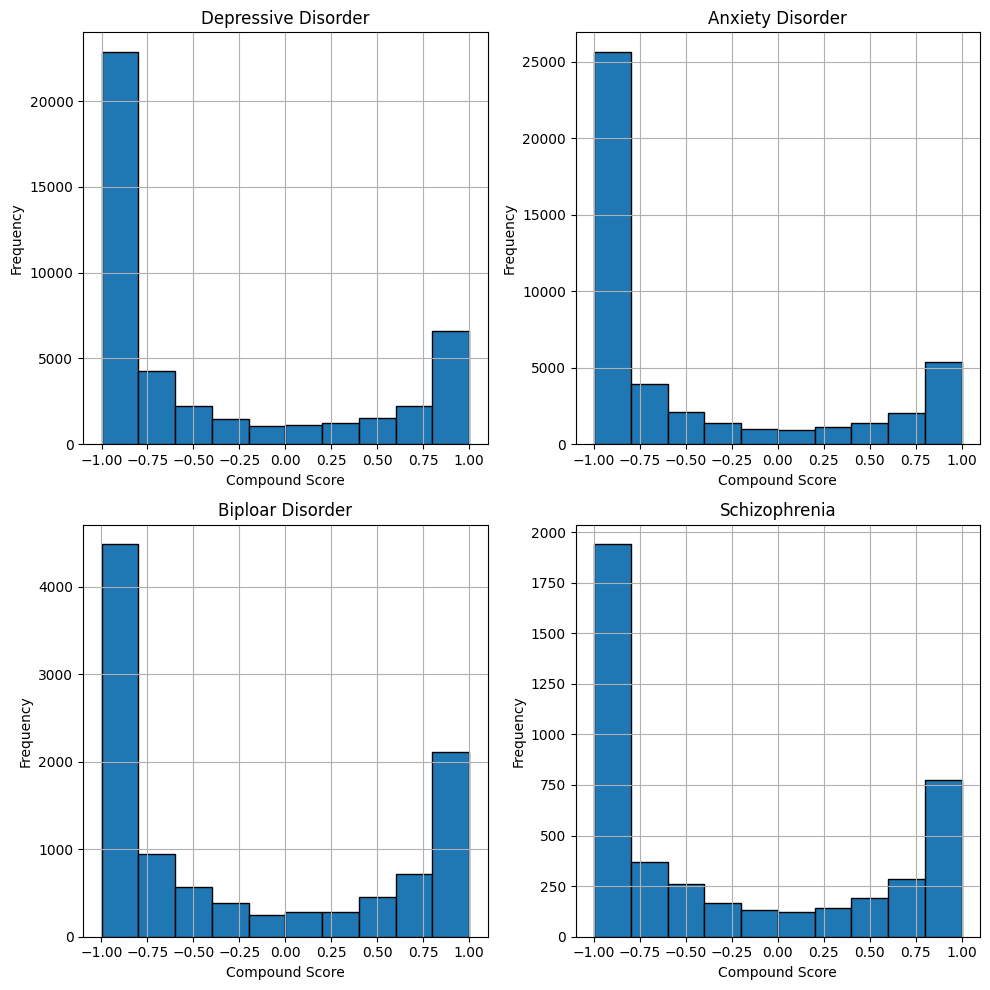

In [ ]:
yearly_compound_score = suicidal_depression[['compound','year']].groupby('year')['compound'].median()

fig, axes = plt.subplots(2, 2,figsize=(10,10))

# Plot the compound scores
axes[0,0].hist(suicidal_depression['compound'], bins=10, edgecolor='black')
axes[0,0].set_xlabel('Compound Score')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Depressive Disorder')
axes[0,0].grid(True)

yearly_compound_score = suicidal_anxiety[['compound','year']].groupby('year')['compound'].median()

# Plot the compound scores
axes[0,1].hist(suicidal_anxiety['compound'], bins=10, edgecolor='black')
axes[0,1].set_xlabel('Compound Score')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Anxiety Disorder')
axes[0,1].grid(True)

yearly_compound_score = suicidal_bipolar[['compound','year']].groupby('year')['compound'].median()
axes[1,0].hist(suicidal_bipolar['compound'], bins=10, edgecolor='black')
axes[1,0].set_xlabel('Compound Score')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Biploar Disorder')
axes[1,0].grid(True)

yearly_compound_score = suicidal_schizophrenia[['compound','year']].groupby('year')['compound'].median()
axes[1,1].hist(suicidal_schizophrenia['compound'], bins=10, edgecolor='black')
axes[1,1].set_xlabel('Compound Score')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Schizophrenia')
axes[1,1].grid(True)


plt.tight_layout()
plt.show()

In [ ]:
pre_bipolar_posts= bipolar['selftext'].astype('str').apply(lambda x: pre_process(x))
bipolar['scores'] = pre_bipolar_posts.apply(lambda post: analyzer.polarity_scores(post))
bipolar['compound']  = bipolar['scores'].apply(lambda score_dict: score_dict['compound'])
bipolar['comp_score'] = bipolar['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')

pre_schizophrenia_posts= schizophrenia['selftext'].astype('str').apply(lambda x: pre_process(x))
schizophrenia['scores'] = pre_schizophrenia_posts.apply(lambda post: analyzer.polarity_scores(post))
schizophrenia['compound']  = schizophrenia['scores'].apply(lambda score_dict: score_dict['compound'])
schizophrenia['comp_score'] = schizophrenia['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')

pre_depression_posts= depression['selftext'].astype('str').apply(lambda x: pre_process(x))
depression['scores'] = pre_depression_posts.apply(lambda post: analyzer.polarity_scores(post))
depression['compound']  = depression['scores'].apply(lambda score_dict: score_dict['compound'])
depression['comp_score'] = depression['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')

pre_anxiety_posts= anxiety['selftext'].astype('str').apply(lambda x: pre_process(x))
anxiety['scores'] = pre_anxiety_posts.apply(lambda post: analyzer.polarity_scores(post))
anxiety['compound']  = anxiety['scores'].apply(lambda score_dict: score_dict['compound'])
anxiety['comp_score'] = anxiety['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')

Text(0.5, 1.0, 'Box Plot of Compound Scores for Four Disorers')

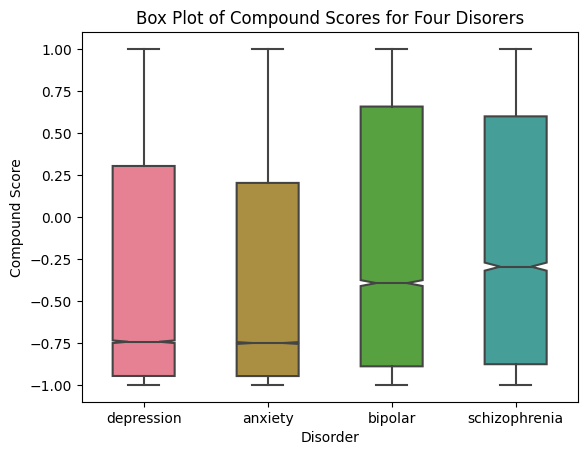

In [ ]:
data = [depression['compound'], anxiety['compound'], bipolar['compound'], schizophrenia['compound']]

ax = sns.boxplot(data=data, notch=True, width=0.5, palette=sns.color_palette("husl"))
ax.set_xticklabels(['depression', 'anxiety', 'bipolar', 'schizophrenia'])
plt.xlabel('Disorder')
plt.ylabel('Compound Score')
plt.title('Box Plot of Compound Scores for Four Disorers')

N-gram Analysis

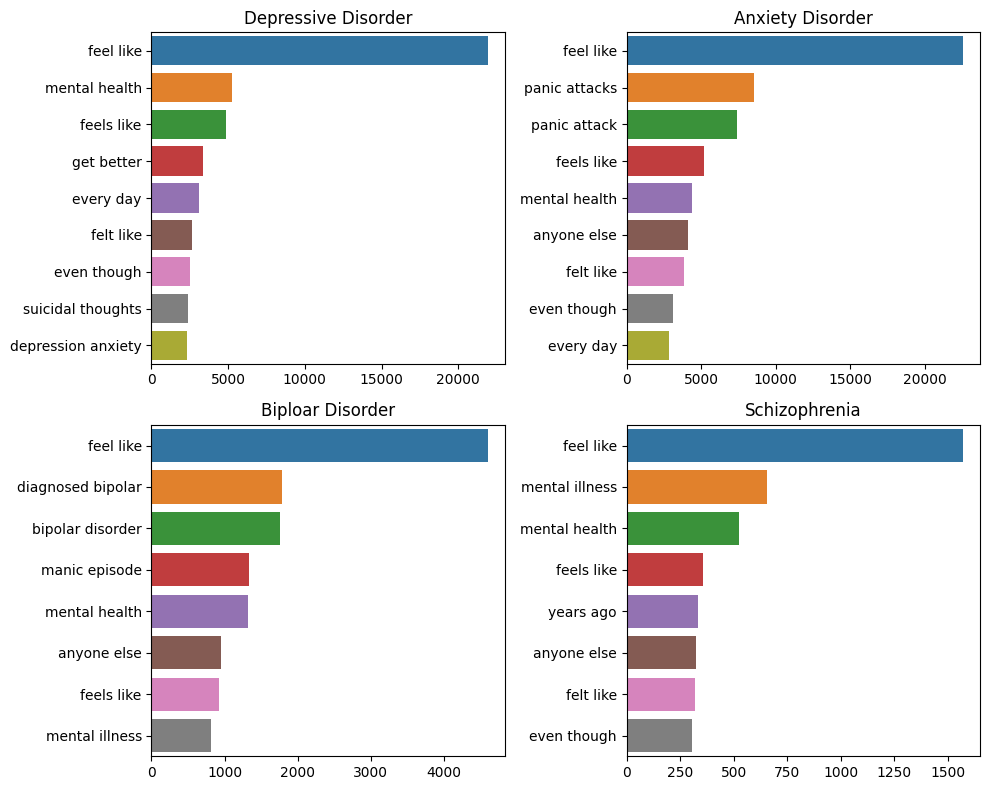

In [ ]:
fig, axes = plt.subplots(2, 2,figsize=(10,8))

top_n_bigrams=get_top_ngram(suicidal_depression['selftext'].astype('str'),2)
x,y=map(list,zip(*top_n_bigrams[:9]))
sns.barplot(x=y,y=x, ax=axes[0,0])
axes[0,0].set_title('Depressive Disorder')


top_n_bigrams=get_top_ngram(suicidal_anxiety['selftext'].astype('str'),2)
x,y=map(list,zip(*top_n_bigrams[:9]))
sns.barplot(x=y,y=x, ax=axes[0,1])
axes[0,1].set_title('Anxiety Disorder')

top_n_bigrams=get_top_ngram(suicidal_bipolar['selftext'].astype('str'),2)
x,y=map(list,zip(*top_n_bigrams[:8]))
sns.barplot(x=y,y=x, ax=axes[1,0])
axes[1,0].set_title('Biploar Disorder')

top_n_bigrams=get_top_ngram(suicidal_schizophrenia['selftext'].astype('str'),2)
x,y=map(list,zip(*top_n_bigrams[:8]))
sns.barplot(x=y,y=x, ax=axes[1,1])
axes[1,1].set_title('Schizophrenia')


plt.tight_layout()
plt.show()

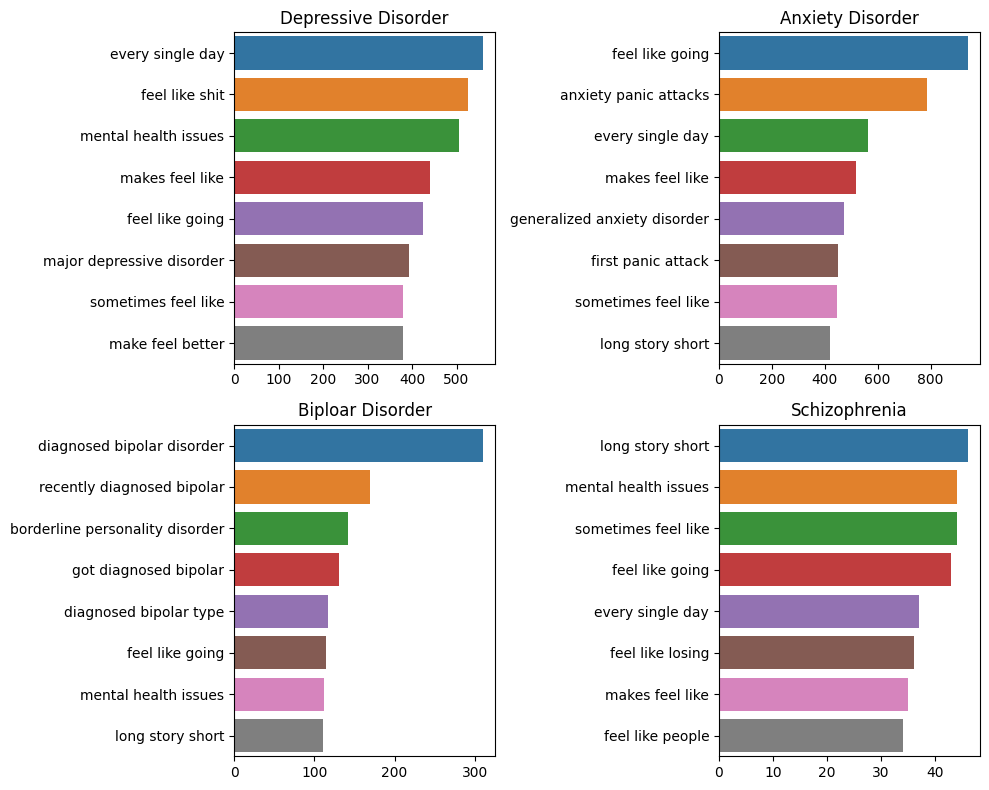

In [ ]:
fig, axes = plt.subplots(2, 2,figsize=(10,8))

top_n_bigrams=get_top_ngram(suicidal_depression['selftext'].astype('str'),3)
x,y=map(list,zip(*top_n_bigrams[:8]))
sns.barplot(x=y,y=x, ax=axes[0,0])
axes[0,0].set_title('Depressive Disorder')


top_n_bigrams=get_top_ngram(suicidal_anxiety['selftext'].astype('str'),3)
x,y=map(list,zip(*top_n_bigrams[:8]))
sns.barplot(x=y,y=x, ax=axes[0,1])
axes[0,1].set_title('Anxiety Disorder')

top_n_bigrams=get_top_ngram(suicidal_bipolar['selftext'].astype('str'),3)
x,y=map(list,zip(*top_n_bigrams[:8]))
sns.barplot(x=y,y=x, ax=axes[1,0])
axes[1,0].set_title('Biploar Disorder')

top_n_bigrams=get_top_ngram(suicidal_schizophrenia['selftext'].astype('str'),3)
x,y=map(list,zip(*top_n_bigrams[:8]))
sns.barplot(x=y,y=x, ax=axes[1,1])
axes[1,1].set_title('Schizophrenia')


plt.tight_layout()
plt.show()